# Twitter Bot or Not -- Undersampling

In [2]:
# Basics
import pandas as pd
import numpy as np
from collections import Counter

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import *

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model support
from sklearn.model_selection import (train_test_split, cross_val_score, learning_curve, 
                                    KFold, GridSearchCV)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer,
                             plot_confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids

## Data import and setup

In [3]:
raw_df = pd.read_csv('data_files/twitter_human_bots_dataset.csv.zip', index_col=False)

# drop funny index column
raw_df.drop(columns=['Unnamed: 0'], inplace=True)

# Binary classifications for bots and boolean values
raw_df['bot'] = raw_df['account_type'].apply(lambda x: 1 if x == 'bot' else 0)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile'] = raw_df['default_profile'].astype(int)
raw_df['default_profile_image'] = raw_df['default_profile_image'].astype(int)
raw_df['geo_enabled'] = raw_df['geo_enabled'].astype(int)
raw_df['verified'] = raw_df['verified'].astype(int)

# datetime conversion
raw_df['created_at'] = pd.to_datetime(raw_df['created_at'])
# hour created
raw_df['hour_created'] = pd.to_datetime(raw_df['created_at']).dt.hour

In [4]:
# usable df setup
df = raw_df[['bot', 'screen_name', 'created_at', 'hour_created', 'verified', 'location', 'geo_enabled', 'lang', 'default_profile', 
              'default_profile_image', 'favourites_count', 'followers_count', 'friends_count', 'statuses_count',
             'average_tweets_per_day', 'account_age_days']]

In [5]:
# Interesting features to look at: 
df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
df['avg_daily_favorites'] = np.round(df['followers_count'] / df['account_age_days'])

# Log transformations for highly skewed data
df['friends_log'] = np.round(np.log(1 + df['friends_count']), 3)
df['followers_log'] = np.round(np.log(1 + df['followers_count']), 3)
df['favs_log'] = np.round(np.log(1 + df['favourites_count']), 3)
df['avg_daily_tweets_log'] = np.round(np.log(1+ df['average_tweets_per_day']), 3)

# Possible popularity metrics
df['popularity'] = np.round(df['friends_log'] * df['followers_log'], 3)
df['tweet_to_followers'] = np.round(np.log( 1+ df['statuses_count']) * np.log(1+ df['followers_count']), 3)

# Log-transformed daily acquisition metrics for dist. plots
df['follower_acq_rate'] = np.round(np.log(1 + (df['followers_count'] / df['account_age_days'])), 3)
df['friends_acq_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)
df['favs_rate'] = np.round(np.log(1 + (df['friends_count'] / df['account_age_days'])), 3)

<ipython-input-5-f05b6e00d5a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_followers'] = np.round(df['followers_count'] / df['account_age_days'])
<ipython-input-5-f05b6e00d5a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['avg_daily_friends'] = np.round(df['followers_count'] / df['account_age_days'])
<ipython-input-5-f05b6e00d5a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [6]:
del raw_df

In [7]:
num_bots = len(df[df['bot'] == 1])
num_humans = len(df[df['bot'] == 0])

print("Number of bots: ", num_bots)
print("Number of humans: ", num_humans)
print("Bots / Total %: ", (num_bots / len(df)) * 100)

Number of bots:  12425
Number of humans:  25013
Bots / Total %:  33.18820449810353


In [7]:
features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            'favs_rate'
           ]

X = df[features]
y = df['bot']

In [8]:
humans = y.value_counts()[0]
bots = y.value_counts()[1]

print(humans, bots)

estimate = humans/bots

print(estimate)

25013 12425
2.013118712273642


In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=34)

## No undersampling

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

forest_acc, forest_prec, forest_rec, forest_f1, forest_roc_auc = [], [], [], [], []
xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Random Forest
    forest = RandomForestClassifier()
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)

    forest_acc.append(accuracy_score(y_val, forest_pred))
    forest_prec.append(precision_score(y_val, forest_pred))
    forest_rec.append(recall_score(y_val, forest_pred))
    forest_f1.append(f1_score(y_val, forest_pred))
    forest_roc_auc.append(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

    # XGBoost
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))


print("RandomForest")
print("------------")
print(f'Accuracy:  {np.mean(forest_acc):.5f} +- {np.std(forest_acc):5f}')
print(f'Precision: {np.mean(forest_prec):.5f} +- {np.std(forest_prec):5f}')
print(f'Recall:    {np.mean(forest_rec):.5f} +- {np.std(forest_rec):5f}')
print(f'F1 Score:  {np.mean(forest_f1):.5f} +- {np.std(forest_f1):5f}')
print(f'ROC AUC:   {np.mean(forest_roc_auc):.5f} +- {np.std(forest_roc_auc):5f}')
print("")
print("XGBoost")
print("-------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

RandomForest
------------
Accuracy:  0.87449 +- 0.003794
Precision: 0.85271 +- 0.007459
Recall:    0.75243 +- 0.015016
F1 Score:  0.79931 +- 0.007551
ROC AUC:   0.92651 +- 0.004169

XGBoost
-------
Accuracy:  0.87511 +- 0.003728
Precision: 0.84753 +- 0.007629
Recall:    0.76128 +- 0.014165
F1 Score:  0.80198 +- 0.006883
ROC AUC:   0.92825 +- 0.004622


## Using `class_weight=balanced`

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

forest_acc, forest_prec, forest_rec, forest_f1, forest_roc_auc = [], [], [], [], []
xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Random Forest
    forest = RandomForestClassifier(class_weight='balanced')
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_val)

    forest_acc.append(accuracy_score(y_val, forest_pred))
    forest_prec.append(precision_score(y_val, forest_pred))
    forest_rec.append(recall_score(y_val, forest_pred))
    forest_f1.append(f1_score(y_val, forest_pred))
    forest_roc_auc.append(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

    # XGBoost
    xgb = XGBClassifier(scale_pos_weight=estimate)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))


print("RandomForest")
print("------------")
print(f'Accuracy:  {np.mean(forest_acc):.5f} +- {np.std(forest_acc):5f}')
print(f'Precision: {np.mean(forest_prec):.5f} +- {np.std(forest_prec):5f}')
print(f'Recall:    {np.mean(forest_rec):.5f} +- {np.std(forest_rec):5f}')
print(f'F1 Score:  {np.mean(forest_f1):.5f} +- {np.std(forest_f1):5f}')
print(f'ROC AUC:   {np.mean(forest_roc_auc):.5f} +- {np.std(forest_roc_auc):5f}')
print("")
print("XGBoost")
print("-------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

RandomForest
------------
Accuracy:  0.87304 +- 0.002982
Precision: 0.85844 +- 0.008770
Recall:    0.74027 +- 0.015246
F1 Score:  0.79482 +- 0.006422
ROC AUC:   0.92723 +- 0.004145

XGBoost
-------
Accuracy:  0.86793 +- 0.002505
Precision: 0.79516 +- 0.006969
Recall:    0.81196 +- 0.010780
F1 Score:  0.80338 +- 0.002875
ROC AUC:   0.92812 +- 0.004449


## Undersampling

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

forest_acc, forest_prec, forest_rec, forest_f1, forest_roc_auc = [], [], [], [], []
xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # Undersampling
    X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train, y_train)
    
    # Random Forest
    forest = RandomForestClassifier()
    forest.fit(X_under, y_under)
    forest_pred = forest.predict(X_val)

    forest_acc.append(accuracy_score(y_val, forest_pred))
    forest_prec.append(precision_score(y_val, forest_pred))
    forest_rec.append(recall_score(y_val, forest_pred))
    forest_f1.append(f1_score(y_val, forest_pred))
    forest_roc_auc.append(roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))

    # XGBoost
    xgb = XGBClassifier()
    xgb.fit(X_under, y_under)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))


print("RandomForest")
print("------------")
print(f'Accuracy:  {np.mean(forest_acc):.5f} +- {np.std(forest_acc):5f}')
print(f'Precision: {np.mean(forest_prec):.5f} +- {np.std(forest_prec):5f}')
print(f'Recall:    {np.mean(forest_rec):.5f} +- {np.std(forest_rec):5f}')
print(f'F1 Score:  {np.mean(forest_f1):.5f} +- {np.std(forest_f1):5f}')
print(f'ROC AUC:   {np.mean(forest_roc_auc):.5f} +- {np.std(forest_roc_auc):5f}')
print("")
print("XGBoost")
print("-------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

RandomForest
------------
Accuracy:  0.85557 +- 0.004833
Precision: 0.75697 +- 0.007401
Recall:    0.83272 +- 0.013975
F1 Score:  0.79298 +- 0.008368
ROC AUC:   0.92665 +- 0.005175

XGBoost
-------
Accuracy:  0.85618 +- 0.004090
Precision: 0.75887 +- 0.008216
Recall:    0.83164 +- 0.011676
F1 Score:  0.79351 +- 0.005850
ROC AUC:   0.92604 +- 0.004182


## Evaluation

XGBoost with SMOTE oversampling - no parameter tuning: 
```
XGBoost
-------
Accuracy:  0.87259 +- 0.002498        # Best Score        
Precision: 0.82089 +- 0.006591        # Best Score
Recall:    0.78777 +- 0.008624
F1 Score:  0.80395 +- 0.005084        # Best Score        
ROC AUC:   0.92863 +- 0.003112        # Best Score
```

XGBoost with `scale_pos_weight` - no paramter tuning:
```
XGBoost
-------
Accuracy:  0.86793 +- 0.002505
Precision: 0.79516 +- 0.006969
Recall:    0.81196 +- 0.010780        # Best Score
F1 Score:  0.80338 +- 0.002875
ROC AUC:   0.92812 +- 0.004449

```


In [13]:
xgb = XGBClassifier(scale_pos_weight=estimate)
xgb.fit(X, y)
xgb_pred = xgb.predict(X_test)

print(f'Accuracy:  {accuracy_score(y_test, xgb_pred):5f}')
print(f'Precision: {precision_score(y_test, xgb_pred):5f}')
print(f'Recall:    {recall_score(y_test, xgb_pred):5f}')
print(f'F1 Score:  {f1_score(y_test, xgb_pred):5f}')
print(f'ROC AUC:   {roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]):5f}')

Accuracy:  0.861912
Precision: 0.785790
Recall:    0.800808
F1 Score:  0.793228
ROC AUC:   0.925910


In [14]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7517
           1       0.79      0.80      0.79      3715

    accuracy                           0.86     11232
   macro avg       0.84      0.85      0.84     11232
weighted avg       0.86      0.86      0.86     11232



ROC AUC score =  0.9259097056094118


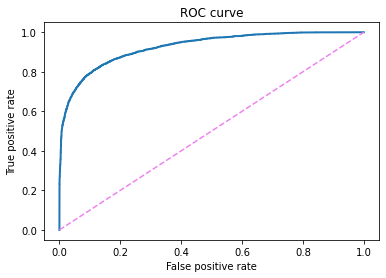

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');
print("ROC AUC score = ", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

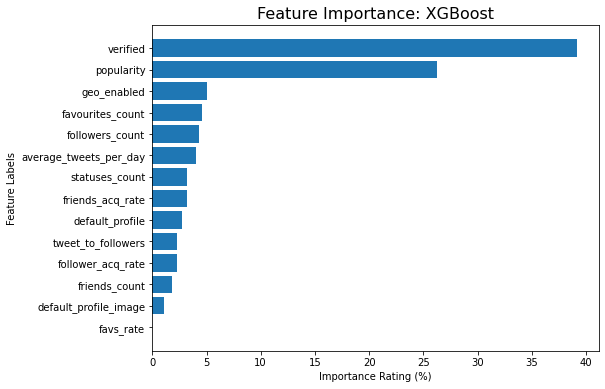

In [16]:
# set up feature_importance
importance = xgb.feature_importances_
feature_importance = list(zip(features, importance))

feature_importance.sort(key = lambda x: x[1])

# split sorted features_importance into x,y
feat = [f[0] for f in feature_importance]
imp = [i[1]*100 for i in feature_importance]

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.title('Feature Importance: XGBoost', fontsize=16)
plt.barh(feat, imp)
plt.xlabel('Importance Rating (%)')
plt.ylabel('Feature Labels');

## Feature tinkering

### XGBoost

In [23]:
df2 = df.copy()

features = ['verified', 
            #'created_at',
            #'hour_created',
            'geo_enabled', 
            'default_profile', 
            'default_profile_image', 
            'favourites_count', 
            'followers_count', 
            #'friends_count', 
            'statuses_count', 
            'average_tweets_per_day',
            #'avg_daily_followers', 
            #'avg_daily_friends',
            #'avg_daily_favorites',
            'popularity', 
            'tweet_to_followers', 
            'follower_acq_rate', 
            'friends_acq_rate', 
            #'favs_rate'
           ]

X = df2[features]
y = df2['bot']

X, X_test, y, y_test = train_test_split(X, y, test_size=.3, random_state=34)

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=33)

xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_roc_auc = [], [], [], [], []

X_kf, y_kf = np.array(X), np.array(y)

for train_ind, val_ind in kf.split(X, y):

    X_train, y_train = X_kf[train_ind], y_kf[train_ind]
    X_val, y_val = X_kf[val_ind], y_kf[val_ind]
    
    # XGBoost
    xgb = XGBClassifier(scale_pos_weight=estimate)
    xgb.fit(X_train, y_train)
    xgb_pred = xgb.predict(X_val)

    xgb_acc.append(accuracy_score(y_val, xgb_pred))
    xgb_prec.append(precision_score(y_val, xgb_pred))
    xgb_rec.append(recall_score(y_val, xgb_pred))
    xgb_f1.append(f1_score(y_val, xgb_pred))
    xgb_roc_auc.append(roc_auc_score(y_val, xgb.predict_proba(X_val)[:,1]))


print("XGBoost")
print("-------")
print(f'Accuracy:  {np.mean(xgb_acc):.5f} +- {np.std(xgb_acc):5f}')
print(f'Precision: {np.mean(xgb_prec):.5f} +- {np.std(xgb_prec):5f}')
print(f'Recall:    {np.mean(xgb_rec):.5f} +- {np.std(xgb_rec):5f}')
print(f'F1 Score:  {np.mean(xgb_f1):.5f} +- {np.std(xgb_f1):5f}')
print(f'ROC AUC:   {np.mean(xgb_roc_auc):.5f} +- {np.std(xgb_roc_auc):5f}')

XGBoost
-------
Accuracy:  0.86866 +- 0.003099
Precision: 0.79528 +- 0.010474
Recall:    0.81463 +- 0.015476
F1 Score:  0.80468 +- 0.007131
ROC AUC:   0.92802 +- 0.004870


XGBoost with SMOTE oversampling - no parameter tuning: 
```
XGBoost
-------
Accuracy:  0.87259 +- 0.002498        # Best Score        
Precision: 0.82089 +- 0.006591        # Best Score
Recall:    0.78777 +- 0.008624
F1 Score:  0.80395 +- 0.005084    
ROC AUC:   0.92863 +- 0.003112        # Best Score
```

XGBoost with `scale_pos_weight` - no paramter tuning:
```
XGBoost
-------
Accuracy:  0.86793 +- 0.002505
Precision: 0.79516 +- 0.006969
Recall:    0.81196 +- 0.010780
F1 Score:  0.80338 +- 0.002875
ROC AUC:   0.92812 +- 0.004449

```

XGBoost -- drop `favs_rate` feature
```
XGBoost
-------
Accuracy:  0.86866 +- 0.003099
Precision: 0.79528 +- 0.010474
Recall:    0.81463 +- 0.015476        # Best Score
F1 Score:  0.80468 +- 0.007131        # Best Score
ROC AUC:   0.92802 +- 0.004870
```